# Import needed modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [ ]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks**
<br>
Callbacks : Helpful functions to help optimize model training  <br>
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# **Model Structure**

#### **Start Reading Dataset**

In [ ]:
!unzip "/content/drive/MyDrive/Skripsi - Plant Leaf/Dataset/New Dataset - PlantLeafDataset.zip" -d "/content/drive/MyDrive/Skripsi - Plant Leaf/"

In [ ]:
data_dir = '/content/drive/MyDrive/Skripsi - Plant Leaf/New Dataset - PlantLeafDataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 32
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 27683 validated image filenames belonging to 36 classes.
Found 5932 validated image filenames belonging to 36 classes.
Found 5933 validated image filenames belonging to 36 classes.


In [ ]:
train_gen.class_indices

{'Jagung_Blight': 0,
 'Jagung_Common_Rust': 1,
 'Jagung_Gray_Leaf_Spot': 2,
 'Jagung_Healthy': 3,
 'Kentang__Early_blight': 4,
 'Kentang__Healthy': 5,
 'Kentang__Late_blight': 6,
 'Mangga_Anthracnose': 7,
 'Mangga_Bacterial_Canker': 8,
 'Mangga_Gall_Midge': 9,
 'Mangga_Healthy': 10,
 'Mangga_Powdery_Mildew': 11,
 'Mangga_Sooty_Mould': 12,
 'Nangka_Algal_Leaf_Spot': 13,
 'Nangka_Black_Spot': 14,
 'Nangka_Healthy': 15,
 'Padi_Bacterialblight': 16,
 'Padi_Blast': 17,
 'Padi_Brownspot': 18,
 'Pisang_Cordana': 19,
 'Pisang_Healthy': 20,
 'Pisang_Pestalotiopsis': 21,
 'Pisang_Sigatoka': 22,
 'Selada_Bacterial': 23,
 'Selada_Fungal': 24,
 'Selada_Healthy': 25,
 'Singkong_Bacterial_Blight': 26,
 'Singkong_Brown_Streak_Disease': 27,
 'Singkong_Green_Mottle': 28,
 'Singkong_Healthy': 29,
 'Singkong_Mosaic_Disease': 30,
 'Tebu_Healthy': 31,
 'Tebu_Mosaic': 32,
 'Tebu_RedRot': 33,
 'Tebu_Rust': 34,
 'Tebu_Yellow': 35}

#### **Display Image Sample**

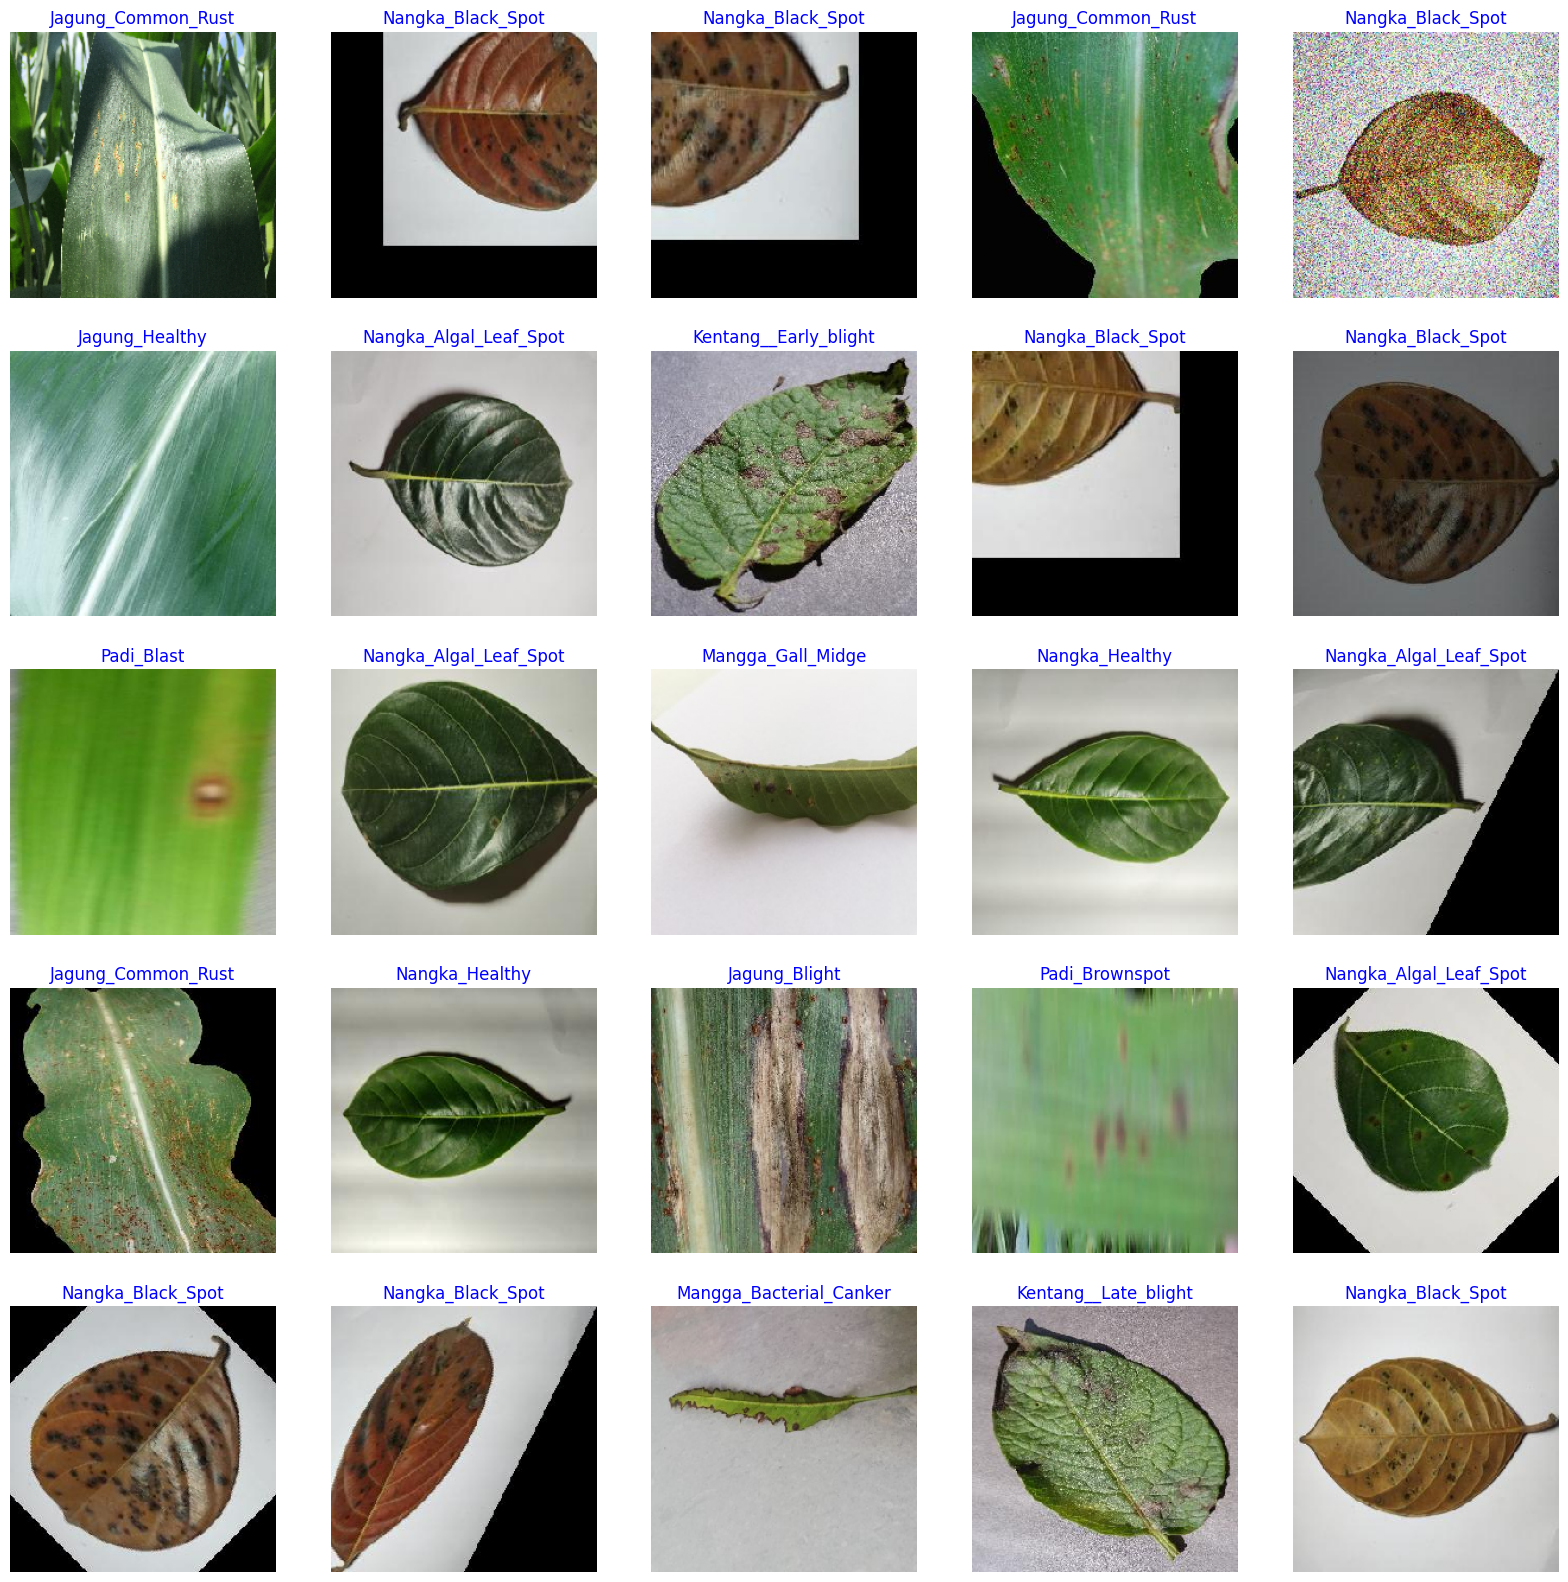

In [ ]:
show_images(train_gen)

#### **Generic Model Creation**

In [ ]:
from tensorflow.keras import Model, regularizers

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb5 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'avg')

# Build the model
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
predictions = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Get summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]'] 

#### **Set Callback Parameters**

In [ ]:
batch_size = 32   # set batch size for training
epochs = 5   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### **Train model**

In [ ]:
history = model.fit(x= train_gen, epochs= 5, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /5      0.305   98.703   0.34511  96.932   0.00100  0.00100  val_loss     0.00    300.02 
 2 /5      0.276   98.934   0.33954  96.797   0.00100  0.00100  val_loss     1.61    300.54 
 3 /5      0.254   99.082   0.32343  96.949   0.00100  0.00100  val_loss     4.75    299.98 
 4 /5      0.238   99.129   0.29747  96.831   0.00100  0.00100  val_loss     8.03    299.70 
 5 /5      0.220   99.310   0.30781  96.746   0.00100  0.00050  val_loss    -3.48    300.90 
training elapsed time was 0.0 hours, 25.0 minutes, 2.11 seconds)


In [ ]:
model.save('/content/drive/MyDrive/Skripsi - Plant Leaf/Checkpoint/EfficientNetB5.h5')

#### **Display model performance**

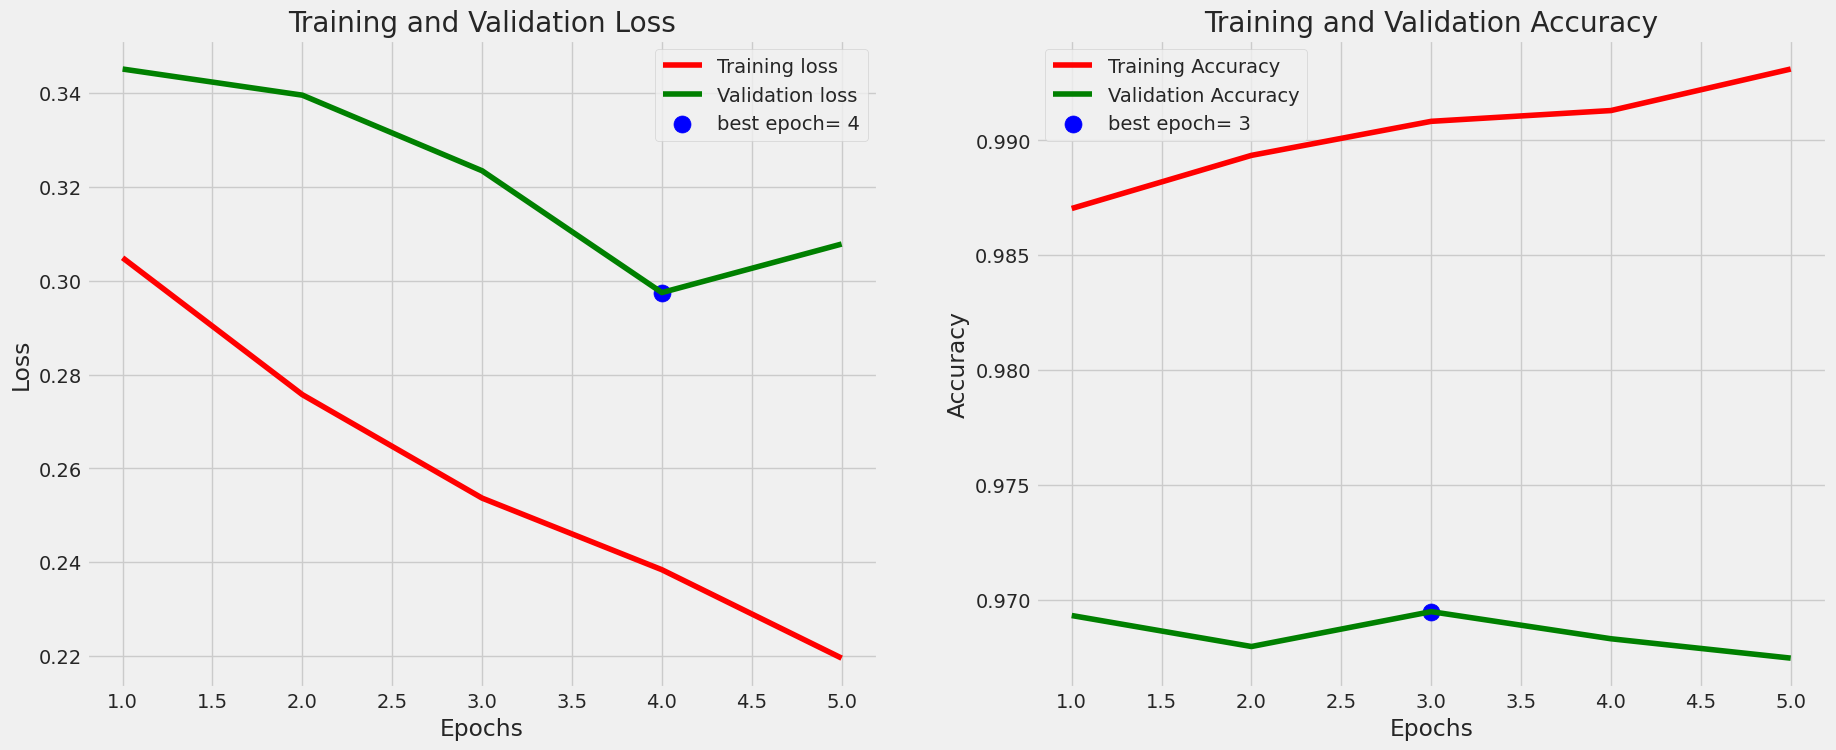

In [ ]:
plot_training(history)

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

185/349 [==============>...............] - ETA: 25s - loss: 0.2977 - accuracy: 0.9682

349/349 [==============================] - 32s 88ms/step - loss: 0.3110 - accuracy: 0.9648
Train Loss:  0.19318820536136627
Train Accuracy:  0.9969555735588074
--------------------
Validation Loss:  0.29746559262275696
Validation Accuracy:  0.9683074951171875
--------------------
Test Loss:  0.31102845072746277
Test Accuracy:  0.9647732973098755


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[14 13 32 ...  2  6 16]


#### **Confusion Matrics and Classification Report**

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                               precision    recall  f1-score   support

                Jagung_Blight       0.86      0.97      0.91       172
           Jagung_Common_Rust       0.97      0.99      0.98       196
        Jagung_Gray_Leaf_Spot       1.00      0.70      0.82        86
               Jagung_Healthy       0.99      1.00      1.00       175
        Kentang__Early_blight       1.00      1.00      1.00       150
             Kentang__Healthy       1.00      1.00      1.00        23
         Kentang__Late_blight       1.00      1.00      1.00       150
           Mangga_Anthracnose       1.00      1.00      1.00        75
      Mangga_Bacterial_Canker       1.00      1.00      1.00        75
            Mangga_Gall_Midge       1.00      1.00      1.00        75
               Mangga_Healthy       1.00      1.00      1.00        75
        Mangga_Powdery_Mildew       1.00      1.00      1.00        75
           Mangga_Sooty_Mould       1.00      1.00      1.00        75
     

In [ ]:
# Dapatkan indeks kelas dari generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Dapatkan label sebenarnya dan prediksi
y_true = test_gen.classes
y_pred = model.predict(test_gen)  # model.predict menghasilkan output probabilitas
y_pred = np.argmax(y_pred, axis=1)  # Ubah probabilitas menjadi indeks kelas

# Hitung TP, TN, FP, FN untuk setiap kelas
conf_matrix = confusion_matrix(y_true, y_pred)
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (FP + FN + TP)

# Hitung Accuracy, Sensitivity, Specificity, dan Precision untuk setiap kelas
Accuracy = (TP + TN) / (TP + FP + FN + TN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)

# Buat laporan klasifikasi
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

# Tambahkan TP, TN, FP, FN, Accuracy, Sensitivity, Specificity, dan Precision ke laporan
for i, class_name in enumerate(classes):
    report[class_name]['TP'] = int(TP[i])
    report[class_name]['TN'] = int(TN[i])
    report[class_name]['FP'] = int(FP[i])
    report[class_name]['FN'] = int(FN[i])
    report[class_name]['Acc'] = f"{Accuracy[i]:.2f}"
    report[class_name]['Sen'] = f"{Sensitivity[i]:.2f}"
    report[class_name]['Spe'] = f"{Specificity[i]:.2f}"
    report[class_name]['Pre'] = f"{Precision[i]:.2f}"

# Print laporan klasifikasi
for class_name in classes:
    print(f"{class_name}:")
    print(f" TP {report[class_name]['TP']}", end="")
    print(f" TN {report[class_name]['TN']}", end="")
    print(f" FP {report[class_name]['FP']}", end="")
    print(f" FN {report[class_name]['FN']}", end="")
    print(f" Acc {report[class_name]['Acc']}%", end="")
    print(f" Sen {report[class_name]['Sen']}%", end="")
    print(f" Spe {report[class_name]['Spe']}%", end="")
    print(f" Pre {report[class_name]['Pre']}%")
    print()

349/349 [==============================] - 30s 85ms/step
Jagung_Blight:
 TP 166 TN 5734 FP 27 FN 6 Acc 0.99% Sen 0.97% Spe 1.00% Pre 0.86%

Jagung_Common_Rust:
 TP 194 TN 5732 FP 5 FN 2 Acc 1.00% Sen 0.99% Spe 1.00% Pre 0.97%

Jagung_Gray_Leaf_Spot:
 TP 60 TN 5847 FP 0 FN 26 Acc 1.00% Sen 0.70% Spe 1.00% Pre 1.00%

Jagung_Healthy:
 TP 175 TN 5757 FP 1 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 0.99%

Kentang__Early_blight:
 TP 150 TN 5783 FP 0 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 1.00%

Kentang__Healthy:
 TP 23 TN 5910 FP 0 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 1.00%

Kentang__Late_blight:
 TP 150 TN 5783 FP 0 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 1.00%

Mangga_Anthracnose:
 TP 75 TN 5858 FP 0 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 1.00%

Mangga_Bacterial_Canker:
 TP 75 TN 5858 FP 0 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 1.00%

Mangga_Gall_Midge:
 TP 75 TN 5858 FP 0 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 1.00%

Mangga_Healthy:
 TP 75 TN 5858 FP 0 FN 0 Acc 1.00% Sen 1.00% Spe 1.00% Pre 

#### **Save model**

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'Plant Village Disease'
acc = test_score[1] * 100
save_path = '/content/drive/MyDrive/Skripsi - Plant Leaf/Checkpoint/'

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as /content/drive/MyDrive/Skripsi - Plant Leaf/Checkpoint/i-Plant Village Disease-96.48.h5
weights were saved as /content/drive/MyDrive/Skripsi - Plant Leaf/Checkpoint/i-Plant Village Disease-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [ ]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

# **Load Model**

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Skripsi - Plant Leaf/Checkpoint/EfficientNetB5.h5')

## **Grad-CAM**

In [ ]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array

In [ ]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

1/1 [==============================] - 0s 39ms/step


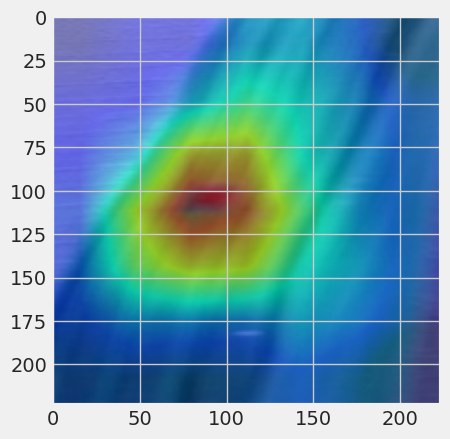

In [ ]:
#load image
test_img = cv2.imread("/content/drive/MyDrive/Skripsi - Plant Leaf/New Dataset - PlantLeafDataset/Padi_Brownspot/BROWNSPOT1_021.jpg")

# Resize the test_img to (240, 240)
resized_test_img = cv2.resize(test_img, (224, 224))

#apply function
VizGradCAM(model, img_to_array(resized_test_img), plot_results=True)

In [ ]:
def VizGradCAMBB(model, image, interpolant=0.5, plot_results=True, threshold=0.5):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    # Enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results:
        overlaid_img = np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))

        # Apply thresholding to the heatmap
        thresholded_heatmap = cv2.threshold(activation_map, 255 * threshold, 255, cv2.THRESH_BINARY)[1]

        # Find contours in the thresholded heatmap
        contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(overlaid_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.imshow(overlaid_img)
    else:
        return cvt_heatmap

1/1 [==============================] - 0s 38ms/step


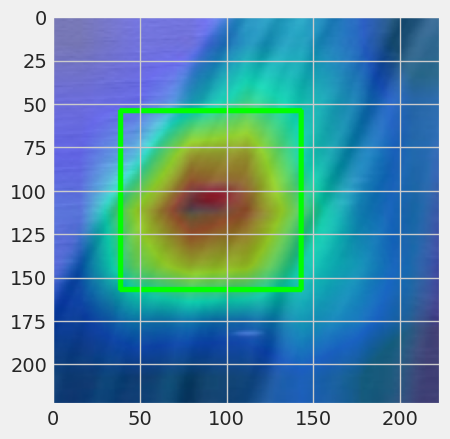

In [ ]:
#load image
test_img = cv2.imread("/content/drive/MyDrive/Skripsi - Plant Leaf/New Dataset - PlantLeafDataset/Padi_Brownspot/BROWNSPOT1_021.jpg")

# Resize the test_img to (240, 240)
resized_test_img = cv2.resize(test_img, (224, 224))

#apply function
VizGradCAMBB(model, img_to_array(resized_test_img), plot_results=True)

In [ ]:
def VizGradCAMBBfix(model, image, interpolant=0.5, plot_results=True, threshold=0.8):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    # Enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results:
        overlaid_img = np.uint8(original_img * interpolant)

        # Apply thresholding to the heatmap
        thresholded_heatmap = cv2.threshold(activation_map, 255 * threshold, 255, cv2.THRESH_BINARY)[1]

        # Find contours in the thresholded heatmap
        contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(overlaid_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.imshow(overlaid_img)
    else:
        return activation_map  # Return activation map without heatmap

1/1 [==============================] - 0s 35ms/step


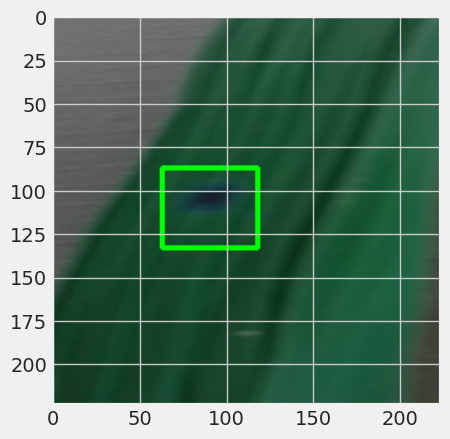

In [ ]:
#load image
test_img = cv2.imread("/content/drive/MyDrive/Skripsi - Plant Leaf/New Dataset - PlantLeafDataset/Padi_Brownspot/BROWNSPOT1_021.jpg")

# Resize the test_img to (240, 240)
resized_test_img = cv2.resize(test_img, (224, 224))

#apply function
VizGradCAMBBfix(model, img_to_array(resized_test_img), plot_results=True)

In [ ]:
test_datagen = ImageDataGenerator()

test_data = test_datagen.flow_from_directory('/content/drive/MyDrive/Skripsi - Plant Leaf/Dataset - PlantLeafDataset - Split/test',
                                        target_size=(224, 224),
                                        class_mode='categorical',
                                        shuffle=False)

Found 1879 images belonging to 21 classes.


In [ ]:
[train_gen.class_indices.keys()]

[dict_keys(['Jagung_Blight', 'Jagung_Common_Rust', 'Jagung_Gray_Leaf_Spot', 'Jagung_Healthy', 'Kentang__Early_blight', 'Kentang__Healthy', 'Kentang__Late_blight', 'Mangga_Anthracnose', 'Mangga_Bacterial_Canker', 'Mangga_Gall_Midge', 'Mangga_Healthy', 'Mangga_Powdery_Mildew', 'Mangga_Sooty_Mould', 'Nangka_Algal_Leaf_Spot', 'Nangka_Black_Spot', 'Nangka_Healthy', 'Padi_Bacterialblight', 'Padi_Blast', 'Padi_Brownspot', 'Pisang_Cordana', 'Pisang_Healthy', 'Pisang_Pestalotiopsis', 'Pisang_Sigatoka', 'Selada_Bacterial', 'Selada_Fungal', 'Selada_Healthy', 'Singkong_Bacterial_Blight', 'Singkong_Brown_Streak_Disease', 'Singkong_Green_Mottle', 'Singkong_Healthy', 'Singkong_Mosaic_Disease', 'Tebu_Healthy', 'Tebu_Mosaic', 'Tebu_RedRot', 'Tebu_Rust', 'Tebu_Yellow'])]

In [ ]:
class_names = ['Jagung_Blight', 'Jagung_Common_Rust', 'Jagung_Gray_Leaf_Spot', 'Jagung_Healthy', 'Kentang__Early_blight', 'Kentang__Healthy', 'Kentang__Late_blight', 'Mangga_Anthracnose', 'Mangga_Bacterial_Canker', 'Mangga_Gall_Midge', 'Mangga_Healthy', 'Mangga_Powdery_Mildew', 'Mangga_Sooty_Mould', 'Nangka_Algal_Leaf_Spot', 'Nangka_Black_Spot', 'Nangka_Healthy', 'Padi_Bacterialblight', 'Padi_Blast', 'Padi_Brownspot', 'Pisang_Cordana', 'Pisang_Healthy', 'Pisang_Pestalotiopsis', 'Pisang_Sigatoka', 'Selada_Bacterial', 'Selada_Fungal', 'Selada_Healthy', 'Singkong_Bacterial_Blight', 'Singkong_Brown_Streak_Disease', 'Singkong_Green_Mottle', 'Singkong_Healthy', 'Singkong_Mosaic_Disease', 'Tebu_Healthy', 'Tebu_Mosaic', 'Tebu_RedRot', 'Tebu_Rust', 'Tebu_Yellow']

1/1 [==============================] - 0s 39ms/step


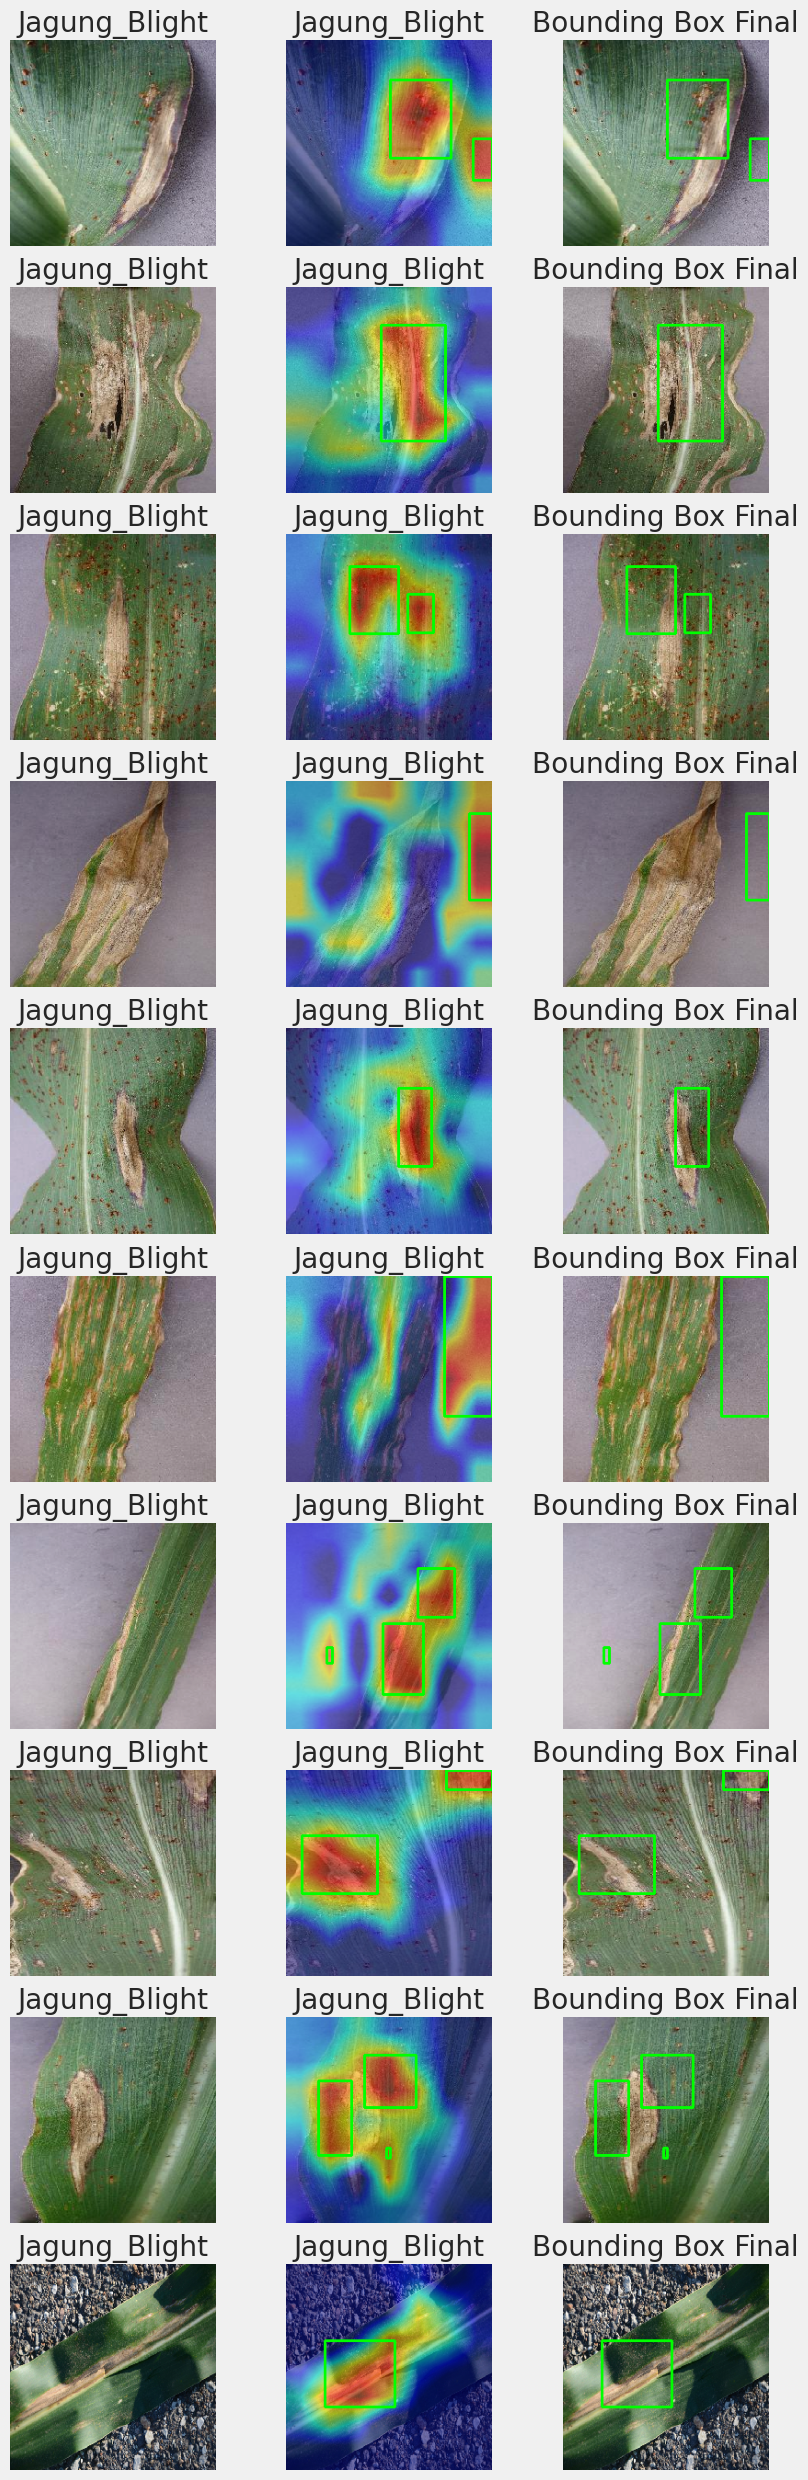

In [ ]:
def VizGradCAMBB_batch(model, test_data, num_images, threshold, interpolant=0.5):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # Fetch a batch of test data
    batch_images, batch_labels = next(test_data)

    # Enlarge plot
    plt.rcParams["figure.dpi"] = 100

    fig, axes = plt.subplots(num_images, 3, figsize=(9, 3 * num_images))

    for i in range(num_images):
        original_img = np.asarray(batch_images[i], dtype=np.float32)
        img = np.expand_dims(original_img, axis=0)
        prediction = model.predict(img)
        prediction_idx = np.argmax(prediction)

        last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
        target_layer = model.get_layer(last_conv_layer.name)

        with tf.GradientTape() as tape:
            gradient_model = Model([model.inputs], [target_layer.output, model.output])
            conv2d_out, prediction = gradient_model(img)
            loss = prediction[:, prediction_idx]

        gradients = tape.gradient(loss, conv2d_out)
        output = conv2d_out[0]
        weights = tf.reduce_mean(gradients[0], axis=(0, 1))
        activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

        for idx, weight in enumerate(weights):
            activation_map += weight * output[:, :, idx]

        activation_map = cv2.resize(activation_map.numpy(),
                                    (original_img.shape[1],
                                     original_img.shape[0]))
        activation_map = np.maximum(activation_map, 0)
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
        activation_map = np.uint8(255 * activation_map)

        heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
        original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
        cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        cvt_heatmap = img_to_array(cvt_heatmap)

        # Plot original image in the left column with label
        true_label = class_names[np.argmax(batch_labels[i])]
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(true_label)
        axes[i, 0].axis('off')

        # Plot Grad-CAM result in the middle column
        overlaid_img = np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))

        # Apply thresholding to the heatmap
        thresholded_heatmap = cv2.threshold(activation_map, 255 * threshold, 255, cv2.THRESH_BINARY)[1]

        # Find contours in the thresholded heatmap
        contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(overlaid_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        axes[i, 1].imshow(overlaid_img)
        axes[i, 1].set_title(class_names[prediction_idx])
        axes[i, 1].axis('off')

        # Plot the final image with bounding boxes only in the right column
        bounding_box_img = np.copy(original_img)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(bounding_box_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        axes[i, 2].imshow(bounding_box_img)
        axes[i, 2].set_title("Bounding Box Final")
        axes[i, 2].axis('off')

    plt.show()

# Example usage
VizGradCAMBB_batch(model, test_data, num_images=10, threshold=0.75, interpolant=0.5)